
# Problem Set 5: Trees, Forests, and Fairness in ML


Your mission for this problem set is to use your knowledge of tree-based methods and supervised learning to -- among other things! -- explore issues of fairness in machine learning (ML). Unlike in previous psets, where we were implementing algorithms from scratch, this pset will rely more heavily on sklearn. Unless explicitly noted otherwise, you are allowed (encouraged!) to make good use of this wonderful library. 

This problem set will also rely on the resources provided by the [folktables](https://github.com/socialfoundations/folktables?tab=readme-ov-file) project. Before getting started, take some time to understand what folktables is about and how it can be used to benchmark ML algorithms in social science. If you don't understand the basics, this pset will be very challenging!!

Some resources you might find useful:

[Folktables paper](https://arxiv.org/abs/2108.04884)

[Folktables video](youtube.com/watch?v=KP7DhM_ahHI)

[PUMS_Data_Dictionary_2018](https://www2.census.gov/programssurveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2018.pdf)

[Fairness in ML](https://fairmlbook.org/classification.html)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folktables
import seaborn as sns

## Part I: Setup of prediction task

### Question 4: Define the income prediction task

For this first question we are providing the code. Run it to download the data you'll be using throughout this problem set. 

Begin by answering the following questions:

* Where do the data come from?
* What is the sample?
* What are we trying to predict?
* What are the features that we will be using?
* What is the "group" feature?


In [2]:
from folktables import ACSDataSource, generate_categories

def adult_filter(data):
    """Mimic the filters in place for Adult data.

    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    return df

ACSIncome = folktables.BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'POBP',
        'RELP',
        'WKHP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,
    group='RAC1P',
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncome.features, definition_df=definition_df)
features, target, group = ACSIncome.df_to_pandas(acs_data)

feature_names = ACSIncome.features
target_name = ACSIncome.target
group_name = ACSIncome.group

The data is sourced from the American Community Survey (ACS) in 2018. The sample is made up of individuals residing in the State of California. The task is to predict whether an individual's annual income exceeds $50,000. The following features are included: age (AGEP), worker classification (COW), educational attainment(SCHL), marital status (MAR), place of birth (POBP), relationship to household head (RELP), hours worked per week (WKHP), sex (SEX) and race (RAC1P). The group feature is self-identified race (RAC1P).

### Question 5: Split into train and test

Split your data into 80%-20% train and test splits. 

In [5]:
from sklearn.model_selection import train_test_split

# your code here
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features.copy(), 
    target.copy(), 
    group, 
    test_size=0.2, 
    random_state=0
)

### Question 6: Data Cleaning

Remember to identify which features are best represented as numerical data types, and which ones are best represented as categorical data types. 
- Set each feature to its desired data type in both train and test splits. Make sure that the target variable in both splits is numeric before moving ahead.


In [6]:
# your code here

categorical_features = ['COW','POBP','SEX','MAR','RAC1P','RELP']
for feature in categorical_features:
    X_train[feature] = X_train[feature].astype('category')
    X_test[feature] = X_test[feature].astype('category')
    
numeric_features = ['AGEP','WKHP','SCHL']

y_train = y_train.astype(int)


### Question 7: Entropy and Information Gain

As we discussed in lecture, decision trees (and their variants) recursively split your dataset into smaller and smaller samples. Let's review how these splits are placed!

For this exercise, consider a really simple decision tree, with only 1 feature: WKHP. Given our income prediction task (defined above), your task is to determine whether it would be better to split this feature at WKHP = 40, or WKHP = 50.

Your tasks:
- Complete the function *weighted_entropy*. The function takes as input a feature, a split point for the feature, and the target. The function returns the entropy (as defined and discussed in the lectures) for that particular split. 
- Using this function, calculate and report the entropy gain from 1) placing a split at WKHP = 40 and 2) placing a split at WKHP = 50. 
- State your conclusion: is it better (in terms of information gain) to split the feature WKHP at the value 40 or the value 50?

Hint: review pages 25 - 30 in Lecture 12: Decision Trees 

In [8]:
def weighted_entropy(x, y, split_point):
    y_left, y_right = y[x <= split_point], y[x > split_point]
    
    p_left = y_left.mean().item()
    p_right = y_right.mean().item()
    
    e_left = -1*(p_left * np.log2(p_left) + (1 - p_left) * np.log2(1 - p_left))
    e_right = -1*(p_right * np.log2(p_right) + (1 - p_right) * np.log2(1 - p_right))
    
    weight_left = len(y_left)/len(y)
    weight_right = len(y_right)/len(y)
    
    e_weighted = weight_left*e_left + weight_right*e_right
    return e_weighted


## Initial entropy
py = np.mean(y_train.values)
e_initial =  -1*(py* np.log2(py) + (1-py)*np.log2(1-py))

## entropy for split at 40
e_40 = weighted_entropy(X_train['WKHP'], y_train, 40)
## entropy for split at 50
e_50 = weighted_entropy(X_train['WKHP'], y_train, 50)

#information gain
gain40 = e_initial - e_40
gain50 = e_initial - e_50

print(gain40, gain50)

0.054386750605591394 0.015103455236762597


Here, the information gain from placing the split at 40 is greater than the information gain from placing the split at 50. Thus, 40 is the better choice!

## Part II: ML pipeline for a Classification Tree

Next, you'll build an ML pipeline using sklearn. Take some time to familiarize yourself with [sklearn.pipeline.Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) before proceeding.

### Question 8: Pre-processing of features

The first step of the pipeline will standardize the numeric features and one-hot encode the categorical features. Write the code for this preprocessing step below. 

**Hint**: Take a look at sklearn's ColumnTransformer, OneHotEncoder and StandardScaler for this task. 

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# your code here

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore",), categorical_features),
    ]
)

### Question 9: Use your pre-processed data to fit a basic DecisionTreeClassifier

Now, bring together the pre-processing step with a Decision Tree Classifier in a pipeline. For now, use the default values; we'll take care of hyperparameter optimization later. 
- Fit the pipeline on the training data. 
- How deep is the resulting tree? How many leafs are in the tree? 
- Print the 10 variables with highest feature importance and tell us what those importances mean in plain English. 
- Plot the top 3 levels of the fitted decision tree. Make sure that the nodes are appropriately labeled.

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# your code here

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier())]
)

clf.fit(X_train,y_train)

print(f"The depth of the tree is {clf['classifier'].tree_.max_depth}")

df_var_imp = pd.DataFrame(zip(clf[0].get_feature_names_out(), clf['classifier'].feature_importances_), columns=['var','imp'])
print(df_var_imp.sort_values('imp',ascending=False).head(10))

fig, ax = plt.subplots(1, figsize=(40, 40))
tree.plot_tree(clf['classifier'], feature_names=clf[0].get_feature_names(), filled=True, max_depth=4, ax=ax)
plt.show()

The depth of the tree is 72


AttributeError: 'ColumnTransformer' object has no attribute 'get_feature_names_out'

### Question 10: Performance Metrics

Let's evaluate the performance of your classifier. Generate predictions from your fitted model, and calculate the following metrics (on the training dataset):
- accuracy
- precision
- recall
- f1-score

 **Do not use any pre-packaged or canned functions from sklearn to calculate these metrics.** Rather, implement the necessary code to calculate these from scratch. You can continue using DecisionTreeClassifier to generate predictions etc. 


In [ ]:
y_preds = clf.predict(X_train)
y_preds = y_preds.reshape(-1, 1)
y_true = y_train.values


tp = np.sum((y_preds == 1) & (y_true == 1))
fp = np.sum((y_preds == 1) & (y_true == 0))
fn = np.sum((y_preds == 0) & (y_true == 1))
tn = np.sum((y_preds == 0) & (y_true == 0))

accuracy = (tp + tn) / (tp + tn +fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2*precision*recall / (precision + recall)

print(np.round(accuracy, 3), 
      np.round(precision, 3), 
      np.round(recall, 3), 
      np.round(f1_score, 3))

### Question 11: Estimate AUC using K-Fold CV

Calculate the 5-fold cross-validated AUC-ROC for this simple tree pipeline.
- Report the score for each fold as well as the average across all folds. 

**Hint 1**: sklearn.model_selection.cross_val_score is your friend. Setting the verbose option to 3 is useful. 

In [11]:
from sklearn.model_selection import cross_val_score

cv_tree = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc',verbose=3)
print(cv_tree)
print(f"The average cv AUC-ROC is {round(cv_tree.mean(),3)}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.735, total=   9.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s


[CV] .................................... , score=0.739, total=   9.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.6s remaining:    0.0s


[CV] .................................... , score=0.740, total=   9.0s
[CV]  ................................................................
[CV] .................................... , score=0.737, total=   9.0s
[CV]  ................................................................
[CV] .................................... , score=0.735, total=   8.9s
[0.73535605 0.73901996 0.74006623 0.73670438 0.73539419]
The average cv AUC-ROC is 0.737


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   45.5s finished


### Question 12: Estimating AUC using nested CV [extra-credit]

Let's try to improve on the results of the decision tree by tweaking its hyperparameters. Since you already are an expert using nested CV, this is going to be a walk in the park! Compute the nested cv AUC-ROC of a decision tree pipeline. Use 5 folds for the inner loop and 3 folds for the outer loop. Include different values for "max_depth", "max_features" and "max_leave_nodes" in your hyperparameter grid.
 - Ensure that you print out the inner and outer fold scores for all combinations of hyperparams.
 - Report the AUC-ROC of a decision tree pipeline (average over outer fold scores)
 - Report the best hyperparameters used in each outer fold.
 - Interpret your results:
   - Are they stable?
   - To what extent do you think specific hyperparameters might lead to overfitting?
   - How is run-time impacted by your choice of hyperparameters?
   - Is hyperparameter optimization worth the trouble?

**Hint 1**: The pipeline remains the same. You can access the list of all the hyperparams in your pipeline with pipeline.get_params_keys(). Notice the naming convention.

**Hint 2**: [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) are your friends-- especially if you run them with verbose = 3.

**Hint 3**: This gets computationally expensive quickly. Be intelligent about the hyperparameter values you include in the grid and the number of outer and inner folds you use (we use 5 inner folds and 3 outer folds).

In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

# your code here 


clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier())]
)

hyperparam_grid = {
    'classifier__criterion': ['gini'],
    'classifier__max_depth': [None,2,10,35],
    'classifier__max_features':[None,'log2'],
    'classifier__max_leaf_nodes':[None,5,100,1000]
}


grid_search = GridSearchCV(
    clf, 
    hyperparam_grid, 
    scoring="roc_auc", 
    cv=5,
    verbose=3
)

outer_cv = cross_validate(
    grid_search,
    X_train, 
    y_train, 
    cv=3, 
    scoring="roc_auc", 
    return_estimator=True,
    verbose=3
)

for i in range(3):
    print('\n')
    print(f"###### FOLD {i} ######")
    print(f"Test error: {round(outer_cv['test_score'][i],5)}")
    print(f"{outer_cv['estimator'][i].best_params_}")

[CV]  ................................................................
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, score=0.740, total=   5.2s
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, score=0.730, total=   5.1s
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s


[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, score=0.733, total=   5.1s
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None 
[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, score=0.732, total=   5.1s
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None 
[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, score=0.732, total=   5.1s
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=5 
[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=5, score=0.797, total=   0.2s
[CV] classifier__cr

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  2.0min finished


[CV] .................................... , score=0.864, total= 2.0min
[CV]  ................................................................
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, score=0.731, total=   5.1s
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, score=0.732, total=   5.1s
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.2s remaining:    0.0s


[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, score=0.730, total=   5.1s
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None 
[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, score=0.731, total=   5.0s
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None 
[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, score=0.733, total=   5.0s
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=5 
[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=5, score=0.797, total=   0.2s
[CV] classifier__cr

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  2.0min finished


[CV] .................................... , score=0.866, total= 2.0min
[CV]  ................................................................
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, score=0.732, total=   5.0s
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, score=0.726, total=   5.1s
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.0s remaining:    0.0s


[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, score=0.733, total=   5.0s
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None 
[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, score=0.739, total=   5.0s
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None 
[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, score=0.729, total=   5.0s
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=5 
[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=5, score=0.796, total=   0.2s
[CV] classifier__cr

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  2.0min finished


[CV] .................................... , score=0.866, total= 2.0min


###### FOLD 0 ######
Test error: 0.86356
{'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__max_leaf_nodes': 100}


###### FOLD 1 ######
Test error: 0.86647
{'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__max_leaf_nodes': 100}


###### FOLD 2 ######
Test error: 0.86581
{'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__max_leaf_nodes': 100}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.1min finished


[CV 4/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=None;, score=0.711 total time=   0.2s
[CV 5/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=None;, score=0.614 total time=   0.2s
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=5;, score=0.651 total time=   0.2s
[CV 2/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=5;, score=0.632 total time=   0.1s
[CV 3/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=5;, score=0.577 total time=   0.1s
[CV 4/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=5;, score=0.585 total time=   0.1s
[CV 5/5] END classifier__criterion

[CV 5/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=100;, score=0.800 total time=   0.2s
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=1000;, score=0.792 total time=   0.3s
[CV 2/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=1000;, score=0.760 total time=   0.3s
[CV 3/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=1000;, score=0.810 total time=   0.3s
[CV 4/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=1000;, score=0.808 total time=   0.3s
[CV 5/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=1000;, score=0.797 total time=   0.2s
[CV] END ..............

[CV 1/5] END classifier__criterion=gini, classifier__max_depth=2, classifier__max_features=None, classifier__max_leaf_nodes=5;, score=0.774 total time=   0.2s
[CV 2/5] END classifier__criterion=gini, classifier__max_depth=2, classifier__max_features=None, classifier__max_leaf_nodes=5;, score=0.771 total time=   0.2s
[CV 3/5] END classifier__criterion=gini, classifier__max_depth=2, classifier__max_features=None, classifier__max_leaf_nodes=5;, score=0.775 total time=   0.2s
[CV 4/5] END classifier__criterion=gini, classifier__max_depth=2, classifier__max_features=None, classifier__max_leaf_nodes=5;, score=0.769 total time=   0.2s
[CV 5/5] END classifier__criterion=gini, classifier__max_depth=2, classifier__max_features=None, classifier__max_leaf_nodes=5;, score=0.776 total time=   0.2s
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=2, classifier__max_features=None, classifier__max_leaf_nodes=100;, score=0.774 total time=   0.2s
[CV 2/5] END classifier__criterion=gini, cla

[CV 2/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=None, classifier__max_leaf_nodes=1000;, score=0.858 total time=   1.3s
[CV 3/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=None, classifier__max_leaf_nodes=1000;, score=0.864 total time=   1.3s
[CV 4/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=None, classifier__max_leaf_nodes=1000;, score=0.861 total time=   1.3s
[CV 5/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=None, classifier__max_leaf_nodes=1000;, score=0.864 total time=   1.4s
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=None;, score=0.746 total time=   0.2s
[CV 2/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=None;, score=0.785 total time=   0.2s
[CV 3/5] END classifie

[CV 4/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=5;, score=0.535 total time=   0.2s
[CV 5/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=5;, score=0.685 total time=   0.2s
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=100;, score=0.782 total time=   0.2s
[CV 2/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=100;, score=0.751 total time=   0.2s
[CV 3/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=100;, score=0.797 total time=   0.2s
[CV 4/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=100;, score=0.793 total time=   0.2s
[CV 5/5] END classifier__criteri

[CV 4/5] END classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=log2, classifier__max_leaf_nodes=1000;, score=0.783 total time=   0.3s
[CV 5/5] END classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=log2, classifier__max_leaf_nodes=1000;, score=0.790 total time=   0.2s
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=2, classifier__max_features=None, classifier__max_leaf_nodes=None;, score=0.773 total time=   0.2s
[CV 2/5] END classifier__criterion=gini, classifier__max_depth=2, classifier__max_features=None, classifier__max_leaf_nodes=None;, score=0.771 total time=   0.2s
[CV 3/5] END classifier__criterion=gini, classifier__max_depth=2, classifier__max_features=None, classifier__max_leaf_nodes=None;, score=0.774 total time=   0.2s
[CV 4/5] END classifier__criterion=gini, classifier__max_depth=2, classifier__max_features=None, classifier__max_leaf_nodes=None;, score=0.773 total time=   0.2s
[CV 5/5] END classifie

[CV 5/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=None, classifier__max_leaf_nodes=5;, score=0.799 total time=   0.2s
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=None, classifier__max_leaf_nodes=100;, score=0.861 total time=   0.6s
[CV 2/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=None, classifier__max_leaf_nodes=100;, score=0.860 total time=   0.6s
[CV 3/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=None, classifier__max_leaf_nodes=100;, score=0.867 total time=   0.7s
[CV 4/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=None, classifier__max_leaf_nodes=100;, score=0.868 total time=   0.8s
[CV 5/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=None, classifier__max_leaf_nodes=100;, score=0.863 total time=   0.7s
[CV 1/5] END classifier__crite

[CV 1/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=None;, score=0.761 total time=   0.8s
[CV 2/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=None;, score=0.767 total time=   0.7s
[CV 3/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=None;, score=0.758 total time=   0.8s
[CV 4/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=None;, score=0.778 total time=   0.7s
[CV 5/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=None;, score=0.759 total time=   1.1s
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=5;, score=0.646 total time=   0.2s
[CV 2/5] END classifier__

Results are stable: the same hyperaparameters were chosen in the three outer loops and out-of-sample performance was very similar (0.865). Growing deep trees is computationally expensive and doesn't improve the results. Hyperparameter optimization improves AUC by 0.13. 

## Part III: ML pipeline for a random forest

### Question 13: Bare bones random forest
Just as you did for the classification tree, start by training a bare bones random forest using your training data. We will take care of the hyperparameter optimization later, but for the time being, use a maximum tree depth of 15. Hopefully is it clear by now why this is a good idea, since we are going to be training a bunch of trees. You should continue to use the same preprocessing step as before. 

 - How many trees are in the forest?
 - Which are the most important features?
 - Explain the meaning of variable importance in the case of a random forest classifier.

In [14]:
from sklearn.ensemble import RandomForestClassifier

# your code here

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(max_depth=15))]
)

clf.fit(X_train,np.ravel(y_train))

imps = pd.Series(clf['classifier'].feature_importances_,index=clf[0].get_feature_names_out()).sort_values(ascending=False).head(10)
fig, ax = plt.subplots()
imps.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

AttributeError: 'ColumnTransformer' object has no attribute 'get_feature_names_out'

### Question 14: Estimating AUC using K-fold CV 

Calculate the 5-fold cross-validated AUC-ROC for the random forests pipeline. 

- Report the score for each fold as well as the average across all folds. 

**Hint 1**: sklearn.model_selection.cross_val_score is your friend. Setting the verbose option to 3 is useful. 


In [15]:
cv_rf = cross_val_score(clf, X_train, np.ravel(y_train), cv=5, scoring='roc_auc',verbose=3)
print(cv_rf)
print(f"The average cv AUC-ROC is {round(cv_rf.mean(),3)}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.870, total=  20.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.3s remaining:    0.0s


[CV] .................................... , score=0.876, total=  19.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   39.7s remaining:    0.0s


[CV] .................................... , score=0.873, total=  19.8s
[CV]  ................................................................
[CV] .................................... , score=0.873, total=  20.5s
[CV]  ................................................................
[CV] .................................... , score=0.874, total=  19.6s
[0.86970413 0.87609377 0.87266478 0.87334487 0.8739461 ]
The average cv AUC-ROC is 0.873


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished


### Question 15: Estimating AUC using nested CV [extra-credit]

Let's try to improve on the results of the random forest by tweaking its hyperparameters. Build a pipeline that computes the nested cv AUC-ROC. Include different values for "n_estimators", "max_samples","max_features", "max_depth" and "max_leaf_nodes" in your hyperparameter grid. 
- Print out the inner and outer fold scores for all combinations of hyperparams.  
- Report the AUC-ROC of a decision tree pipeline (average over outer fold scores)
- Report the best hyperparams used in each outer fold.
- Interpret your results

What do you notice about these results? How are these results related to those from the decision tree pipeline? Is hyperparameter optimization worth the trouble?

**Hint 1**: The pipeline remains the same. You can acces the list of all the hyperparams in your pipeline with pipeline.get_params_keys(). Notice the naming convention.

**Hint 2**: GridSearchCV and cross_val_score are your friends. Specially if you run them with verbose = 3.

**Hint 3**: This gets computationally expensive quickly. Be intelligent about the hyperparam values you include in the grid.

In [16]:
from sklearn.model_selection import GridSearchCV

# your code here 


clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)

hyperparam_grid = {
    'classifier__n_estimators': [50,100],
    'classifier__max_samples': [0.1,0.5],
    'classifier__max_features':['log2'],
    'classifier__max_depth':[5,10],
    'classifier__max_leaf_nodes':[None,10,100]
}

grid_search = GridSearchCV(
    clf, 
    hyperparam_grid, 
    scoring="roc_auc", 
    cv=5,
    verbose=3
)

outer_cv = cross_validate(
    grid_search,
    X_train, 
    np.ravel(y_train), 
    cv=3, 
    scoring="roc_auc", 
    return_estimator=True,
    verbose=3
)

for i in range(3):
    print('\n')
    print(f"###### FOLD {i} ######")
    print(f"Test error: {round(outer_cv['test_score'][i],3)}")
    print(f"{outer_cv['estimator'][i].best_params_}")

[CV]  ................................................................
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50, score=0.853, total=   0.5s
[CV] classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50, score=0.844, total=   0.5s
[CV] classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50, score=0.843, total=   0.5s
[CV] classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50 
[CV]  classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50, score=0.829, total=   0.5s
[CV] classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50 
[CV]  classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50, score=0.839, total=   0.5s
[CV] classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=100 
[CV

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  2.0min finished


[CV] .................................... , score=0.855, total= 2.0min
[CV]  ................................................................
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50, score=0.846, total=   0.5s
[CV] classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50, score=0.836, total=   0.5s
[CV] classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50, score=0.847, total=   0.5s
[CV] classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50 
[CV]  classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50, score=0.836, total=   0.5s
[CV] classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50 
[CV]  classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50, score=0.854, total=   0.5s
[CV] classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=100 
[CV

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.9min finished


[CV] .................................... , score=0.856, total= 2.0min
[CV]  ................................................................
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50, score=0.835, total=   0.5s
[CV] classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50, score=0.841, total=   0.5s
[CV] classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50, score=0.851, total=   0.5s
[CV] classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50 
[CV]  classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50, score=0.855, total=   0.5s
[CV] classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50 
[CV]  classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50, score=0.838, total=   0.5s
[CV] classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=100 
[CV

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  2.0min finished


[CV] .................................... , score=0.856, total= 2.0min


###### FOLD 0 ######
Test error: 0.855
{'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__max_leaf_nodes': 100, 'classifier__max_samples': 0.1, 'classifier__n_estimators': 100}


###### FOLD 1 ######
Test error: 0.856
{'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__max_leaf_nodes': 100, 'classifier__max_samples': 0.1, 'classifier__n_estimators': 100}


###### FOLD 2 ######
Test error: 0.856
{'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__max_leaf_nodes': None, 'classifier__max_samples': 0.1, 'classifier__n_estimators': 100}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.0min finished


[CV 2/5] END classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=10, classifier__max_samples=0.1, classifier__n_estimators=100;, score=0.844 total time=   1.1s
[CV 3/5] END classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=10, classifier__max_samples=0.1, classifier__n_estimators=100;, score=0.843 total time=   1.0s
[CV 4/5] END classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=10, classifier__max_samples=0.1, classifier__n_estimators=100;, score=0.848 total time=   1.0s
[CV 5/5] END classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=10, classifier__max_samples=0.1, classifier__n_estimators=100;, score=0.850 total time=   0.9s
[CV 1/5] END classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=10, classifier__max_samples=0.5, classifier__n_estimators=50;, score=0.844 total time=   0.7s
[CV 2/5] END classifier__max_depth=10, cl

[CV 4/5] END classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=100;, score=0.853 total time=   1.0s
[CV 5/5] END classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=100;, score=0.839 total time=   1.0s
[CV 1/5] END classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.5, classifier__n_estimators=50;, score=0.838 total time=   0.7s
[CV 2/5] END classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.5, classifier__n_estimators=50;, score=0.837 total time=   0.9s
[CV 3/5] END classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.5, classifier__n_estimators=50;, score=0.856 total time=   0.9s
[CV 4/5] END classifier__max_depth=5, 

[CV 2/5] END classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=100, classifier__max_samples=0.5, classifier__n_estimators=50;, score=0.826 total time=   0.7s
[CV 3/5] END classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=100, classifier__max_samples=0.5, classifier__n_estimators=50;, score=0.838 total time=   0.7s
[CV 4/5] END classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=100, classifier__max_samples=0.5, classifier__n_estimators=50;, score=0.827 total time=   0.7s
[CV 5/5] END classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=100, classifier__max_samples=0.5, classifier__n_estimators=50;, score=0.838 total time=   0.7s
[CV 1/5] END classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=100, classifier__max_samples=0.5, classifier__n_estimators=100;, score=0.843 total time=   1.3s
[CV 2/5] END classifier__max_depth=5, classi

[CV 5/5] END classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=10, classifier__max_samples=0.5, classifier__n_estimators=50;, score=0.829 total time=   0.8s
[CV 1/5] END classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=10, classifier__max_samples=0.5, classifier__n_estimators=100;, score=0.841 total time=   1.4s
[CV 2/5] END classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=10, classifier__max_samples=0.5, classifier__n_estimators=100;, score=0.853 total time=   1.3s
[CV 3/5] END classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=10, classifier__max_samples=0.5, classifier__n_estimators=100;, score=0.848 total time=   1.4s
[CV 4/5] END classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=10, classifier__max_samples=0.5, classifier__n_estimators=100;, score=0.840 total time=   1.4s
[CV 5/5] END classifier__max_depth=10, cl

[CV 2/5] END classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.5, classifier__n_estimators=100;, score=0.841 total time=   1.2s
[CV 3/5] END classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.5, classifier__n_estimators=100;, score=0.838 total time=   1.2s
[CV 4/5] END classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.5, classifier__n_estimators=100;, score=0.847 total time=   1.3s
[CV 5/5] END classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.5, classifier__n_estimators=100;, score=0.834 total time=   1.2s
[CV 1/5] END classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=10, classifier__max_samples=0.1, classifier__n_estimators=50;, score=0.842 total time=   0.6s
[CV 2/5] END classifier__max_depth=5, 

[CV 5/5] END classifier__max_depth=5, classifier__max_features=log2, classifier__max_leaf_nodes=100, classifier__max_samples=0.5, classifier__n_estimators=100;, score=0.846 total time=   1.4s
[CV 1/5] END classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50;, score=0.848 total time=   0.9s
[CV 2/5] END classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50;, score=0.852 total time=   0.9s
[CV 3/5] END classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50;, score=0.856 total time=   0.8s
[CV 4/5] END classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__max_samples=0.1, classifier__n_estimators=50;, score=0.855 total time=   0.9s
[CV 5/5] END classifier__max_depth=1

[CV 3/5] END classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=100, classifier__max_samples=0.1, classifier__n_estimators=50;, score=0.857 total time=   0.9s
[CV 4/5] END classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=100, classifier__max_samples=0.1, classifier__n_estimators=50;, score=0.854 total time=   0.8s
[CV 5/5] END classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=100, classifier__max_samples=0.1, classifier__n_estimators=50;, score=0.853 total time=   0.9s
[CV 1/5] END classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=100, classifier__max_samples=0.1, classifier__n_estimators=100;, score=0.856 total time=   1.6s
[CV 2/5] END classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=100, classifier__max_samples=0.1, classifier__n_estimators=100;, score=0.856 total time=   1.3s
[CV 3/5] END classifier__max_depth=10,

The results appear to be stable. The optimal hyperparameters are not the same but are similar. Performance is stable (~0.86).

### Question 16: Take stock of parts II and III

If you were to choose between a decision tree and a random forest for this classification task, what would be your choice and why? 

Results suggest that both algorithms offer a stable performance with AUC-ROC of roughly 0.86. I would stick to a decision tree since it is a "simpler" model that is easier to visualize and interpret. 

## Part IV: Test data, ROC curves and fairness thresholds

Note that until now, we have not used the test data for any purpose. Let's now incorporate it into our analysis and use it to find a "fair" threshold value.

### Question 17: Find the optimal hyperparameters and fit a decision tree pipeline

Use all of your training data to find the optimal hyperparameters and fit a decision tree pipeline. 
- Report the optimal hyperparameters. 

**Note:** Recall that nested cross-validation is only providing you with an estimate of the out-of-sample performance of the model finding procedure that involves hyperparameter optimization. At training time you should carry out the entire model finding procedure, including hyperparameter optimization. 

In [58]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier())]
)

hyperparam_grid = {
    'classifier__criterion': ['gini'],
    'classifier__max_depth': [None,2,10,35],
    'classifier__max_features':[None,'log2'],
    'classifier__max_leaf_nodes':[None,5,100,1000]
}

grid_search = GridSearchCV(
    clf, 
    hyperparam_grid, 
    scoring="roc_auc", 
    cv=5,
    verbose=3
).fit(X_train,y_train)

fitted_pipeline = grid_search.best_estimator_

print('\n', grid_search.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, score=0.737, total=   9.3s
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s


[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, score=0.740, total=   9.3s
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.6s remaining:    0.0s


[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, score=0.738, total=   9.0s
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None 
[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, score=0.736, total=   9.1s
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None 
[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, score=0.735, total=   8.9s
[CV] classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=5 
[CV]  classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=5, score=0.795, total=   0.3s
[CV] classifier__cr

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  3.3min finished



 {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__max_leaf_nodes': 100}
[CV 2/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=None;, score=0.762 total time=   0.3s
[CV 3/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=None;, score=0.709 total time=   0.3s
[CV 4/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=None;, score=0.710 total time=   0.3s
[CV 5/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=None;, score=0.771 total time=   0.3s
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=log2, classifier__max_leaf_nodes=5;, score=0.515 total time=   0.2s
[CV 2/5] END classifier__criterion=gini, classifier_

[CV 3/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=100;, score=0.756 total time=   0.3s
[CV 4/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=100;, score=0.782 total time=   0.3s
[CV 5/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=100;, score=0.797 total time=   0.3s
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=1000;, score=0.770 total time=   0.4s
[CV 2/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=1000;, score=0.808 total time=   0.4s
[CV 3/5] END classifier__criterion=gini, classifier__max_depth=35, classifier__max_features=log2, classifier__max_leaf_nodes=1000;, score=0.811 total time=   0.4s
[CV 4/5] END classifier__

### Question 18: Scores and the ROC curve

Use the fitted pipeline to compute score values for all instances in the test set. 
- Show the distribution of the scores in a histogram. 
- Additionally, compute the (FPR,TPR) combinations for all relevant threshold values and use them to plot the ROC curve in a different figure. Following the convention, include a dashed line along the diagonal. Remember to label the axes and to make the figures as polished as possible.

**Note 1**: You should NOT be using sklearn.metrics.auc or sklearn.metrics.RocCurveDisplay to calculate or display the ROC curve. Please code this part yourself.

In [60]:
scores = [proba[1] for proba in fitted_pipeline.predict_proba(X_test)]
X_test['score'] = scores
X_test['y'] = y_test

thresholds = np.linspace(0,1,100)
diagonal = [thresholds,thresholds]

fpr = []
tpr = []

num_p = len(X_test[X_test['y']==1])
num_n = len(X_test[X_test['y']==0])

for t in thresholds:
    num_p_hat = len(X_test[(X_test['score'] >= t) & (X_test['y']==1)])
    tpr.append(num_p_hat/num_p)
    num_n_hat = len(X_test[(X_test['score'] >= t) & (X_test['y']==0)])
    fpr.append(num_n_hat/num_n)
    

/home/suraj.nair/.conda/envs/didl-covid/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/suraj.nair/.conda/envs/didl-covid/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/suraj.nair/.conda/envs/didl-covid/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

### Question 19:  ROC curves by racial groups

Compute and plot in the same figure the ROC curves for the following racial groups identified by the ACS:

* White (RAC1P==1) (plot in blue)
* African American (RAC1P==2) (plot in orange)
* Asian American (RAC1P==6) (plot in green)

Interpret the results.

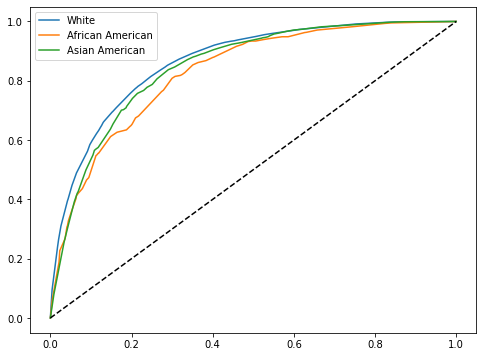

In [61]:
races = {'White':1,'African American':2,'Asian American':6}
colors = {'White':'#1f77b4','African American':'#ff7f0e','Asian American':'#2ca02c'}

thresholds = np.linspace(0,1,100)
diagonal = [thresholds,thresholds]

tprs = {}
fprs = {}

for race,value in races.items():
    tprs[race] = []
    fprs[race] = []

    num_p = len(X_test[(X_test['y']==1) & (X_test['RAC1P']==value)])
    num_n = len(X_test[(X_test['y']==0) & (X_test['RAC1P']==value)])

    for t in thresholds:
        num_p_hat = len(X_test[(X_test['score'] >= t) & (X_test['y']==1) & (X_test['RAC1P']==value)])
        tprs[race].append(num_p_hat/num_p)
        num_n_hat = len(X_test[(X_test['score'] >= t) & (X_test['y']==0) & (X_test['RAC1P']==value)])
        fprs[race].append(num_n_hat/num_n)
        
fig, ax = plt.subplots(1, figsize=(8, 6))

for race in races:
    ax.plot(fprs[race],tprs[race],label=race)
    
_ = ax.plot(thresholds,thresholds,color='black',linestyle='--'),
ax.legend()

### Question 20: Achieving error parity 

Implement a thresholding strategy that satisfies error parity for all racial groups with FPR = 0.25, TPR = 0.7 and $\epsilon$ = 0.025. In plain english, find a way of setting thresholds for the members of each group in the test data that, when evaluated on the test data, delivers FPR and TPR values that differ at most from the objective values by $\epsilon$.  
 - Plot the estimated TPRs and FPRs of the racial groups in the ROC plot. Use star markers, colored accordingly. 

**Hint**: Consider using group-specific stochastic thresholds.

White 1
Hit! White 0.414 0.158 0.699 0.227
African American 2
Hit! African American 0.444 0.105 0.697 0.246
Asian American 6
Hit! Asian American 0.485 0.105 0.704 0.228


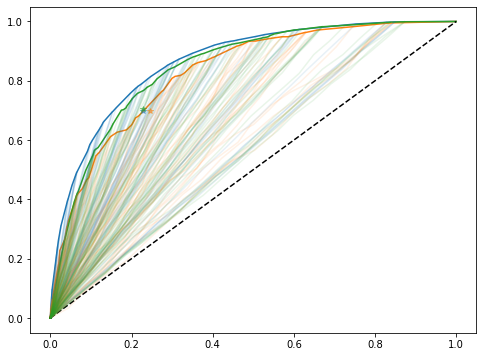

In [85]:
thresholds = np.linspace(0,1,100)
lmdas = np.linspace(0,1,20)

fig, ax = plt.subplots(1, figsize=(8, 6))

for race in races:
    ax.plot(fprs[race],tprs[race],label=race)
    
_ = ax.plot(thresholds,thresholds,color='black',linestyle='--'),


tpr_obj = 0.7
fpr_obj = 0.25
epsilon = 0.025

for race,value in races.items():
    print(race,value)
    X_test_race = X_test[X_test['RAC1P']==value].copy()
    y_test_race = y_test[X_test['RAC1P']==value].copy()
    hit = False
    for threshold in thresholds:
        tpr_t = []
        fpr_t = []
        randomness = np.random.random(len(X_test_race))
        for lmda in lmdas:
            X_test_race.loc[:,'t_alt'] = (randomness > lmda).astype(int)
            X_test_race.loc[:,'t_alt'] = X_test_race['t_alt'].replace(1,1-threshold)
            X_test_race.loc[:,'t_alt'] = X_test_race['t_alt'].replace(0,1)
            
            X_test_race.loc[:,'y_hat'] = (X_test_race['score'] > X_test_race['t_alt']).astype(int)
                         
            tpr = np.mean(X_test_race[
                (X_test_race['y']==1)
            ]['y_hat'])
            
            tpr_t.append(tpr)
                         
            fpr = np.mean(X_test_race[
                (X_test_race['y']==0)
            ]['y_hat'])
            
            fpr_t.append(fpr)
            
            #print(race,round(threshold,3), round(lmda,3), round(tpr,3), round(fpr,3))
            if not(hit):
                if abs(tpr - tpr_obj) < epsilon and abs(fpr - fpr_obj) < epsilon:
                    ax.plot(fpr,tpr,marker='*',color=colors[race],alpha=0.5)
                    print('Hit!',race,round(1-threshold,3), round(lmda,3), round(tpr,3), round(fpr,3))
                    hit = True
                
                
        ax.plot(fpr_t,tpr_t,color=colors[race],alpha=0.1)

The following stochastic thresholds deliver error parity for each group:

* White: Set t = $\infty$ with probability p=0.158 and t=0.41 with probability (1-p) = 0.842.
* Asian American: Set t = $\infty$ with probability p=0.105 and t=0.475 with probability (1-p) = 0.895.
* African American: Set t = $\infty$ with probability p=0.105 and t=0.44 with probability (1-p) = 0.895.

### Question 21: Improving the results

Can you improve the results from Question 20? That is, can you tweak your algorithm to deliver a higher TPR and lower FPR while still satisfying error parity with epsilon = 0.025? 
- What is the best result that you are able to achieve?
- Is there a hard limit on how much you can improve?

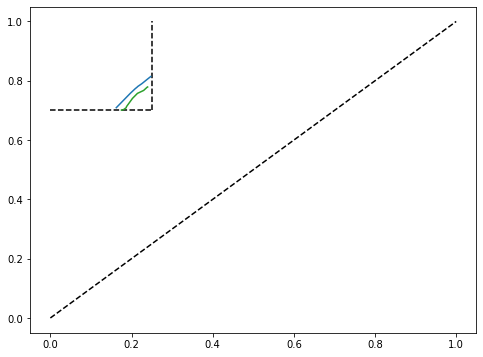

In [86]:
races = {'White':1,'African American':2,'Asian American':6}
colors = {'White':'#1f77b4','African American':'#ff7f0e','Asian American':'#2ca02c'}

thresholds = np.linspace(0,1,100)
lmdas = np.linspace(0,1,20)

fig, ax = plt.subplots(1, figsize=(8, 6))

for race in races:
    masked_fprs = np.array(fprs[race])[(np.array(fprs[race]) < 0.25) & (np.array(tprs[race]) > 0.7)]
    masked_tprs = np.array(tprs[race])[(np.array(fprs[race]) < 0.25) & (np.array(tprs[race]) > 0.7)]
   
    if race == "African American":
        ax.plot(masked_fprs,masked_tprs,label=race,color=colors[race],alpha=1)
        ax.plot(masked_fprs,masked_tprs+0.025,label=race,color=colors[race],linestyle='--')
        ax.plot(masked_fprs-0.025,masked_tprs,label=race,color=colors[race],linestyle='--')
    
    ax.plot(masked_fprs,masked_tprs,label=race,color=colors[race],alpha=1)
    
    
_ = ax.plot(thresholds,thresholds,color='black',linestyle='--')
_ = ax.vlines(x=0.25,ymin=0.7,ymax=1,color='black',linestyle='--')
_ = ax.hlines(y=0.7,xmin=0,xmax=0.25,color='black',linestyle='--')

The region above the lines FPR=0.25 and TPR=0.7 is the region of improvement. Note that the combinations of FPR and TPR values above the solid orange line are not achievable in expectation for the African American group. Hence, if we impose error parity, the FPR and TPR combination of the Asian and White groups will be pegged to the combination of the African American group, regardless of whether more desirable combinations are achievable. 

### Question 22: Conclusion

What can you say about welfare and error parity? Some things to consider:

* In this income prediction task, is enforcing error parity costly?
* Would you expect this results to generalize to other predictions problems?
* Is the group definition relevant?
* Who benefits from enforcing error parity? Who doesn't?


* In this income prediction task, is enforcing error parity costly?

It is costly. It involves pegging the performance of all groups to the performance of the least performing group. 

* Would you expect this results to generalize to other predictions problems?

As long as there are baseline differences in performance across groups, then enforcing error parity will be costly. 

* Is the group definition relevant?

It is essential. For instance, consider the limiting case where the membership variable partitions the population into subgroups such that at least for one group the classifier does no better than randon chance. The only classifier that would meet error parity in this case is a coin toss. 

* Who benefits from enforcing error parity? Who doesn't?

Enforcing error parity leads to a predictor that performs worse in some groups than it could be and it doesn't improve the *absolute* error rate of the protected group. However, it does improve the error rate of the protected group *relative* to toher groups. At the very least, the act of measuring and reporting group specific error rates highlights that different social groups bear different amounts of misclassification. As Barocas and Hardt (2022) suggest, this can incentivize decision makers to work towards improving error rates through collecting better datasets and building better models. If there is no way to improve error rates in some group relative to others, this raises questions about the legitimate use of machine learning in such cases.